# Digit Recognition using Convolutional Neural Network
In this project, we will write a full end-to-end training process using gluon and MXNet.We will train the LeNet-5 classifier network on the MNIST dataset. The steps that we will follow are to prepare the dataset, train the network, and evaluate it's performance on the held out dataset. So lets get started!


* Lets load all the essential Libraries
We will be working with GluonCV for image recognition. It is a part of Apache MXNet ecosystem, a flexible and efficient library for deep learning. 
* *GluonCV* provides implementations of state-of-the-art deep learning algorithms in computer vision. It aims to help engineers, researchers, and students quickly prototype products, validate new ideas and learn computer vision.

In [1]:
# Loading all Libraries and essential Functions
from mxnet import gluon, metric, autograd, init, nd
from mxnet.gluon.data.vision import datasets, transforms

## Get the Data
Once we have imported the functionalites, its time to get the data. MXNet has the MNIST data in *`gluon.data.vision.datasets`*. The function defined below returns training and validation datasets.

In [2]:
# Load MNIST Datasets
def get_mnist_data():
    train_data = gluon.data.vision.datasets.MNIST(train=True)
    #train_data._label[train_data._label > 0] = 1

    val_data = gluon.data.vision.datasets.MNIST(train=False)
    #val_data._label[val_data._label > 0] = 1
    return train_data, val_data

In [3]:
train_data, val_data = get_mnist_data()

## Take a look
Now that the dataset is loaded, lets take a look at the sample from training set. We can visualize a sample image with its label using Matplotlib. To view a different sample, just change the index number at the bottom of the below defined function.

Data type: <class 'numpy.uint8'>
Label: 9


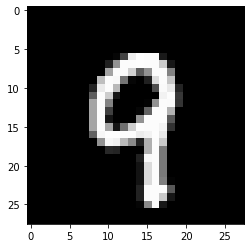

In [14]:
# See samples from the dataset
from matplotlib.pylab import imshow

def view_sample(sample_idx):
    sample = train_data[sample_idx]
    data = sample[0]
    label = sample[1]
    
    imshow(data[:,:,0].asnumpy(), cmap='gray')
    print("Data type: {}".format(data.dtype))
    print("Label: {}".format(label))

#Enter the sample number to view from training dataset    
view_sample(350)

Data type: <class 'numpy.uint8'>
Label: 7


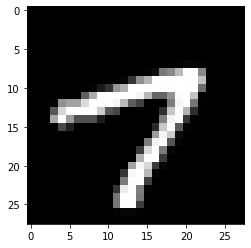

In [15]:
view_sample(101)

## Data Transformation
Data preprocessing and transformation is a common step performed in machine learning to make training robust. Here we perform two types of transformation.
* `ToTensor()`: Converts an image NDArray of shape (H x W x C) in the range [0, 255] to a float32 tensor NDArray of shape (C x H x W) in the range [0, 1].

* `Normalize()`: Normalize an tensor of shape (C x H x W) or (N x C x H x W) with mean and standard deviation.

We have defined the tranformation function below. We will use this function in data loading step

In [5]:
#Define a transformation function
transform_fn = transforms.Compose([transforms.ToTensor(),transforms.Normalize(0.13,0.31)])

## Data Loaders
The dataloader is essentially an iterator which goes through our entire dataset, minibatch by minibatch until all of the dataset samples have been used during training, signaling the end of one epoch. To train neural networks, we typically repeat multiple epochs until convergence of the network parameters.
We define two dataloaders below, one for training data and one for validation data.

The transformations are applied while fetching the data batch. The transformation function that we defined above will be used while loading the dataset to perform transformation. This is called *`LAZY TRANSFORMATION`*.

In [6]:
def get_data_loaders(train_data,val_data,transform_fn,batch):
    
    train_dataloader = gluon.data.DataLoader(train_data.transform_first(transform_fn),
                                      batch_size = batch,
                                       shuffle=True)
    
    validation_dataloader = gluon.data.DataLoader(val_data.transform_first(transform_fn),
                                     batch_size = batch,
                                     shuffle=False)
    #raise NotImplementedError()
    
    return train_dataloader, validation_dataloader

In [7]:
train_loader, val_loader = get_data_loaders(train_data, val_data, transform_fn, batch = 128)

## Define a Network
For multiclass classification, we will use LeNet-5 architecture to define our network. 
* `LeNet-5 CNN` architecture is made up of 7 layers. The layer composition consists of 3 convolutional layers, 2 subsampling layers and 2 fully connected layers.
To learn more about this architecture, please refer to the article below.

https://towardsdatascience.com/understanding-and-implementing-lenet-5-cnn-architecture-deep-learning-a2d531ebc342

In [8]:
net = gluon.nn.Sequential()
net.add(gluon.nn.Conv2D(channels=6, kernel_size=5, activation='relu'), #C1
        gluon.nn.MaxPool2D(pool_size=2, strides=2),                    #S2
        gluon.nn.Conv2D(channels=16, kernel_size=3, activation='relu'),#C3
        gluon.nn.MaxPool2D(pool_size=2, strides=2),                    #S4
        gluon.nn.Flatten(),                                            #Flatten
        gluon.nn.Dense(120, activation="relu"),                        #C5
        gluon.nn.Dense(84, activation="relu"),                         #F6
        gluon.nn.Dense(10))                                            #Output Layer
net.initialize(init=init.Xavier())

## Training Loop
In this step, we will train our network on training data. We follow the steps to write the loop as follows.
* Create the loss function. This should be a loss function suitable for multi-class classification.
* Create the metric accumulator. This should the compute and store the accuracy of the model during training
* Create the trainer with the `adam` optimizer and learning rate of `0.002`


The function returns the trained network after n epochs and training accurracy of each epoch. 

In [9]:
def train(network, training_dataloader, batch_size, epochs):
    """
    Should take an initialized network and train that network using data from the data loader.
    
    :param network: initialized gluon network to be trained
    :type network: gluon.Block
    
    :param training_dataloader: the training DataLoader provides batches for data for every iteration
    :type training_dataloader: gluon.data.DataLoader
    
    :param batch_size: batch size for the DataLoader.
    :type batch_size: int
    
    :param epochs: number of epochs to train the DataLoader
    :type epochs: int
    
    :return: tuple of trained network and the final training accuracy
    :rtype: (gluon.Block, float)
    """
    
    loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()
    
    train_acc = metric.Accuracy()
    trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate' : 0.002})
    
    for epoch in range(epochs):
        train_loss = 0
        
        for data,label in training_dataloader:
            with autograd.record():
                output = net(data)
                loss = loss_fn(output,label)
                
            loss.backward()
            
            trainer.step(batch_size)
            train_loss += loss.mean().asscalar()
            
            train_acc.update(label,output)
        print("Epoch {}".format(epoch))
        print("Training Accuracy {}".format(train_acc.get()[1]))
        
    training_accuracy = train_acc.get()[1]

    return network, training_accuracy

In [10]:
network, train_acc = train(net, train_loader, 128, 5)

Epoch 0
Training Accuracy 0.9431333333333334
Epoch 1
Training Accuracy 0.9625166666666667
Epoch 2
Training Accuracy 0.9705944444444444
Epoch 3
Training Accuracy 0.975275
Epoch 4
Training Accuracy 0.97854


Now that we have trained the network and tested its accuracy on the training set, which is pretty decent, we will also go ahead and test it for validation set.

## Validation Loop
We will take the set of same steps that we did in the training loop. For the validation loop, we only need to predict the label of the data and compute the accuracy. We have defined a validation loop below.

In [11]:
def validate(network, validation_dataloader):
    """
    Should compute the accuracy of the network on the validation set.
    
    :param network: initialized gluon network to be trained
    :type network: gluon.Block
    
    :param validation_dataloader: the training DataLoader provides batches for data for every iteration
    :type validation_dataloader: gluon.data.DataLoader
    
    :return: validation accuracy
    :rtype: float
    """
    
    valid_acc = metric.Accuracy()
    for data, label in validation_dataloader:
        output = net(data)
        valid_acc.update(label,output)
        
    validation_accuracy = valid_acc.get()[1]

    return validation_accuracy

In [12]:
val_acc = validate(net,val_loader)
print("The validation accuracy is {}".format(val_acc))

The validation accuracy is 0.9889


## Finally
To conclude, we used a LeNet-5 CNN for image classification of MNIST data. We are able to predict the labels of hand-written digits using this network. We performed data loading, data transformation, network definition and training and calculated training and validation accuracy.

This project is based on the course that I completed on Coursera. `AWS Computer Vision: Getting Started with GluonCV`.
